## Oxygen saturation and oxygen concentration in density space along float trajectory

### Load packages and define parameters

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import cmocean
from   matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

#### Define custom colormap (purples)

In [6]:
cbb = np.array([[255, 255, 255], [235, 234, 245], [226, 223, 239], [219, 217, 237], 
       [204, 199, 222], [191, 184, 211], [181, 170, 201], [170, 156, 190], 
       [158, 142, 181], [148, 130, 172], [140, 121, 166], [131, 110, 158],
       [122, 100, 150], [116, 91,  144], [106, 79,  137], [97,  68,  130],
       [88,  56,  123], [78,  45,  117]])/256
cmp_prp = LinearSegmentedColormap.from_list(None, cbb)

### Read in float data
Float data available at https://data-argo.ifremer.fr/dac/coriolis/6901023/6901023_Sprof.nc

In [8]:
ds_fl = xr.open_dataset('data/6901023_Sprof.nc')

# Calculate absolute salinity, conservative temperature, potential density, and oxygen saturation
ds_fl['sa']  = gsw.SA_from_SP(ds_fl['PSAL_ADJUSTED'], ds_fl['PRES_ADJUSTED'], ds_fl['LONGITUDE'], ds_fl['LATITUDE']);
ds_fl['ct'] = gsw.CT_from_t(ds_fl['sa'], ds_fl['TEMP_ADJUSTED'], ds_fl['PRES_ADJUSTED']);
ds_fl['sigma'] = gsw.sigma0(ds_fl['sa'], ds_fl['ct']);
ds_fl['o2s'] = gsw.O2sol(ds_fl['sa'], ds_fl['ct'], ds_fl['PRES_ADJUSTED'], ds_fl['LONGITUDE'], ds_fl['LATITUDE'])
ds_fl['sat'] = ds_fl['DOXY_ADJUSTED']/ds_fl['o2s']*100

### Calculate mean oxygen in density bins

In [10]:
# Define function that applies groupby operation
def gb_mean_ufunc(data, group_var, group_bins):
    # Convert inputs (passed as np.ndarray) back to DataArray to run groupby_bins
    return xr.DataArray(data).groupby_bins(xr.DataArray(group_var), bins=group_bins).mean()

# Density grid
sig_grd = np.arange(24, 28, .05)

# Call gb_ufunc to calculate mean oxygen in density bins for each time step
oxy_sig = xr.apply_ufunc(
    gb_mean_ufunc, ds_fl['DOXY_ADJUSTED'], ds_fl['sigma'], sig_grd,
    input_core_dims=[['N_LEVELS'], ['N_LEVELS'], ['sig0']],
    output_core_dims=[['sig0_bins']], 
    vectorize=True,
    output_dtypes=[ds_fl['sigma'].dtype],
) 

# Define sig0_bin coordinate at the bin centers
oxy_sig['sig0_bins'] = (sig_grd[1:] + sig_grd[:-1])/2

### Plot figure

/var/folders/nb/s5nqqv4d7dd70vh3qqgz_3900000gn/T/ipykernel_54779/1373386299.py:20: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb2 = plt.colorbar(c2, ax=ax[1], label='Oxygen concentration [$\mu$mol/kg]')


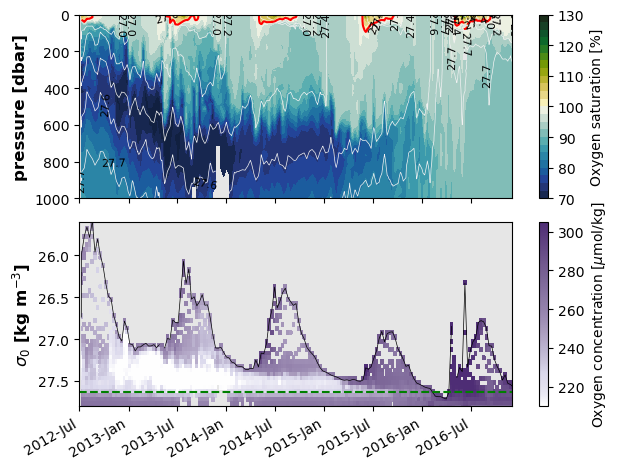

In [12]:
fig, ax = plt.subplots(2, 1, sharex=True, subplot_kw={'facecolor':[0.9, 0.9, 0.9]});
# Plot O2 saturation
c1 = ax[0].contourf(np.tile(ds_fl['JULD'], [122, 1]).T, ds_fl['PRES_ADJUSTED'], 
           ds_fl['sat'], vmin=70, vmax=130, cmap=cmocean.cm.delta, levels=np.arange(60, 140, 2.5))
c1b = ax[0].contour(np.tile(ds_fl['JULD'], [122, 1]).T, ds_fl['PRES_ADJUSTED'], 
             ds_fl['sigma'], levels=[27, 27.2, 27.4, 27.6, 27.7], linewidths=0.5, colors = [[0.95, 0.95, 0.95]])
ax[0].clabel(c1b, colors='k', fontsize=8)
ax[0].contour(np.tile(ds_fl['JULD'], [122, 1]).T, ds_fl['PRES_ADJUSTED'], ds_fl['sat'], levels=[100], colors='r')

# Plot O2 concentration in density space
c2 = ax[1].pcolor(ds_fl['JULD'], oxy_sig['sig0_bins'], oxy_sig.T, shading='nearest', 
             vmin=210, vmax=305, cmap=cmp_prp)
# Plot mixed layer density; index 3 is the first with consistent coverage, mean pressure is 3dbar
ax[1].plot(ds_fl['JULD'], ds_fl['sigma'][:, 3], color='k', linewidth=.5)
# Plot AMOC upper/lower branch boundary
ax[1].hlines(27.63, np.datetime64('2012-07-01'), np.datetime64('2016-12-01'), colors='g', linestyle='--')

# Add labels and adjust figure design
cb1 = plt.colorbar(c1, ax=ax[0], label='Oxygen saturation [%]')
cb2 = plt.colorbar(c2, ax=ax[1], label='Oxygen concentration [$\mu$mol/kg]')
cb1.ax.set_ylim([70, 130]); cb2.ax.set_ylim([210, 305])
ax[0].set_ylim([1000, 0]); ax[1].set_ylim([27.8, 25.6])
ax[0].set_xlim([np.datetime64('2012-07-01'), np.datetime64('2016-12-01')])
ax[0].set_ylabel('pressure [dbar]', fontweight='bold', fontsize=12)
ax[1].set_ylabel('$\sigma_0$ [kg m$^{-3}$]', fontweight='bold', fontsize=12)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.tight_layout()